# EDA on Beer Data

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# reading in data
df = pd.read_csv('../data/beer_reviews_full.csv')
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [3]:
# converting review_times to datetime type
df['review_time'] = pd.to_datetime( df['review_time'], unit = 's' )

C:\Users\Wilson\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


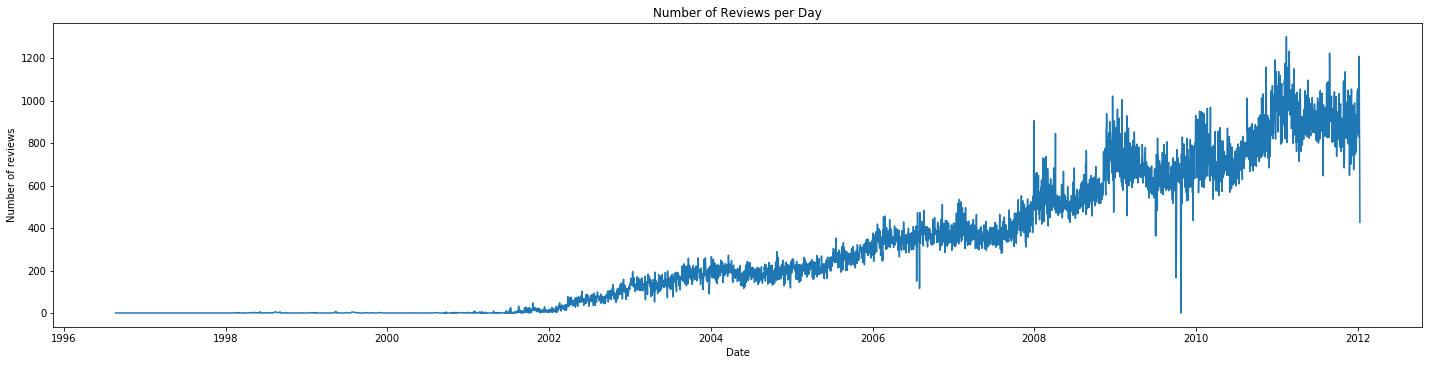

In [4]:
# plotting the number of reviews per day to look for any trends
group_by_date = df[ [ 'review_time' ] ].groupby( df[ 'review_time' ].dt.date ).agg( [ 'count' ] )
plt.figure( figsize = ( 20, 5 ) )
plt.plot( group_by_date )
plt.xlabel( 'Date' )
plt.ylabel( 'Number of reviews' )
plt.tight_layout()
plt.title( 'Number of Reviews per Day' )
plt.savefig('../images/beer_reviews_day.png');

In [5]:
# based on the plot above I am going to drop everything before 2002 because there is almost no data up to this point
df = df.loc[ df[ 'review_time' ].dt.year >= 2002 ]

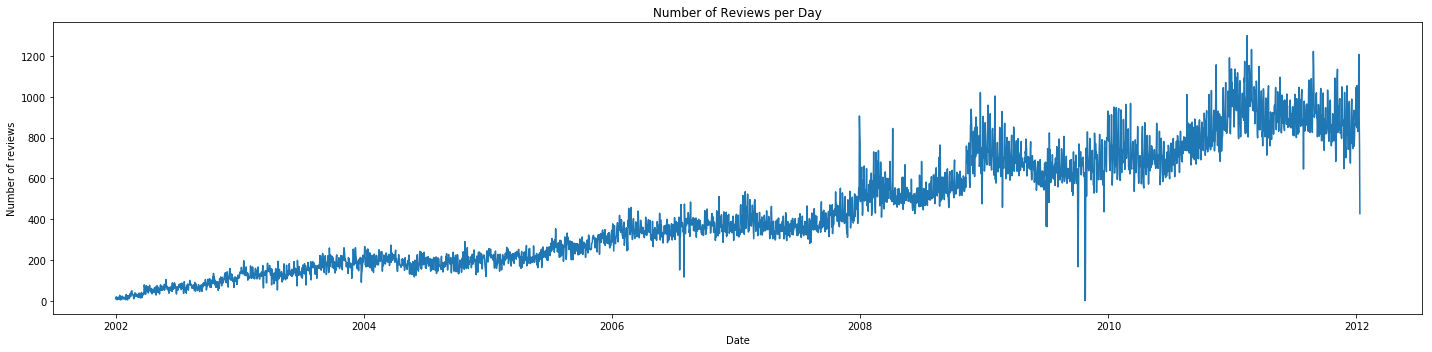

In [6]:
# replotting the number of reviews per day after dropping the data before 2002
group_by_date = df[ [ 'review_time' ] ].groupby( df[ 'review_time' ].dt.date ).agg( [ 'count' ] )
plt.figure( figsize = ( 20, 5 ) )
plt.plot( group_by_date )
plt.xlabel( 'Date' )
plt.ylabel( 'Number of reviews' )
plt.title( 'Number of Reviews per Day' )
plt.tight_layout()
plt.savefig('../images/beer_reviews_day_short.png');

In [7]:
# checking the info and amount of memory the data set requires
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1584276 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1584276 non-null int64
brewery_name          1584261 non-null object
review_time           1584276 non-null datetime64[ns]
review_overall        1584276 non-null float64
review_aroma          1584276 non-null float64
review_appearance     1584276 non-null float64
review_profilename    1583928 non-null object
beer_style            1584276 non-null object
review_palate         1584276 non-null float64
review_taste          1584276 non-null float64
beer_name             1584276 non-null object
beer_abv              1516852 non-null float64
beer_beerid           1584276 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 616.6 MB


In [8]:
# dataset shape
df.shape

(1584276, 13)

In [9]:
# beers with single reviews mess up the recommendation process so I am checking to see how many of these I have
single_count = 0
for i in df['beer_name'].value_counts():
    if i == 1:
        single_count += 1
single_count

18850

In [32]:
df['beer_name'].value_counts()[:10]

90 Minute IPA                          3289
India Pale Ale                         3126
Old Rasputin Russian Imperial Stout    3098
Sierra Nevada Celebration Ale          2987
Two Hearted Ale                        2727
Stone Ruination IPA                    2704
Arrogant Bastard Ale                   2699
Sierra Nevada Pale Ale                 2577
Stone IPA (India Pale Ale)             2574
Pliny The Elder                        2527
Name: beer_name, dtype: int64

In [39]:
df = df[df['beer_name'] != 'India Pale Ale']

In [40]:
df['beer_name'].value_counts()[:10]

90 Minute IPA                          3289
Old Rasputin Russian Imperial Stout    3098
Sierra Nevada Celebration Ale          2987
Two Hearted Ale                        2727
Stone Ruination IPA                    2704
Arrogant Bastard Ale                   2699
Sierra Nevada Pale Ale                 2577
Stone IPA (India Pale Ale)             2574
Pliny The Elder                        2527
Founders Breakfast Stout               2502
Name: beer_name, dtype: int64

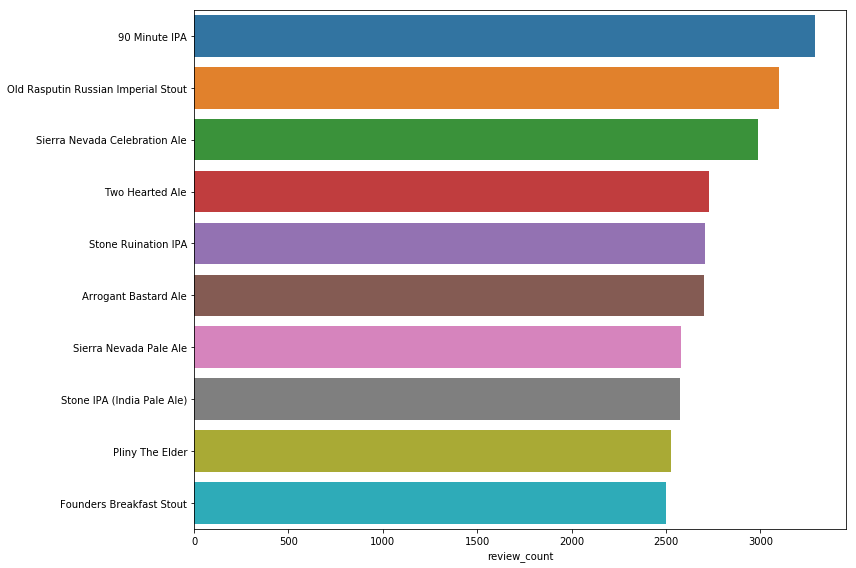

In [41]:
plt.figure(figsize=(12,8))
sns.barplot(df['beer_name'].value_counts()[:10], df['beer_name'].value_counts().index[:10])
plt.tight_layout()
plt.xlabel('review_count');
plt.savefig('../images/most_rated_beers.png')

In [44]:
# making sure I dropped everything correctly and there are no more beers with only 1 review
single_count = 0
for i in df['beer_name'].value_counts():
    if i == 1:
        single_count += 1
single_count

18850

In [45]:
# creating a list of beers to drop from my data set if they only have 1 review
drop_list = []
for (i, j) in zip(df['beer_name'].value_counts(), df['beer_name'].value_counts().index):
    if i == 1:
        drop_list.append(j)

In [46]:
drop_list[:10]

["A Little Sumpin' Stoopid Ale",
 'Little Mike Pale Ale',
 'Extra Hoppy Centennial Ale',
 'X-Extra Pale Ale',
 'Bernard S &#269;istou Hlavou',
 'Churchyard Strong Ale',
 'Pumpkin Honey Wheat',
 'Triple H Hefe Weizen',
 'Brock',
 'Alpena Wheat Ale']

In [47]:
# dropping the beers with only 1 review from my dataset
for i in tqdm(drop_list): # this takes a while so I added a loading bar to track the progress of forloop
    df = df[df['beer_name'] != i]

100%|██████████████████████████████████████████████████████████████████████████| 18850/18850 [1:07:14<00:00,  4.72it/s]


In [48]:
# checking the number of rows after dropping the beers with 1 review
df.shape[0]

1562300

In [49]:
# making sure I dropped everything correctly and there are no more beers with only 1 review
single_count = 0
for i in df['beer_name'].value_counts():
    if i == 1:
        single_count += 1
single_count

0

In [50]:
# checking for nulls
df.isnull().sum()

brewery_id                0
brewery_name              8
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              61478
beer_beerid               0
dtype: int64

In [51]:
# because my dataset is so large I have no issue dropping the null values in the dataset for the review_profilename 
# and brewery_name columns
df.dropna(inplace=True, subset=['review_profilename', 'brewery_name'])
df.isnull().sum()

brewery_id                0
brewery_name              0
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename        0
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              61466
beer_beerid               0
dtype: int64

In [52]:
# dropping unecessary columns for the recommender model to save memory
df_col_drop = df.drop(columns=['brewery_id', 'review_time', 'review_aroma', 'review_appearance', 
                               'beer_style', 'review_palate', 'review_taste', 'beer_abv', 'beer_beerid'])
df_col_drop.head()

,brewery_name,review_overall,review_profilename,beer_name
5,Caldera Brewing Company,3.0,oline73,Caldera Ginger Beer
6,Caldera Brewing Company,3.5,Reidrover,Caldera Ginger Beer
7,Caldera Brewing Company,3.0,alpinebryant,Caldera Ginger Beer
8,Caldera Brewing Company,4.0,LordAdmNelson,Caldera Ginger Beer
9,Caldera Brewing Company,4.5,augustgarage,Caldera Ginger Beer


In [53]:
# saving both shortend dataframe to a csv
df_col_drop.to_csv('../data/beer_reviews_col_drop.csv', index=False)